In [1]:
from keras.models import load_model
import time
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Use CPU only
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers
import keras
import matplotlib.pyplot as plt
import PIL

# Functions for testing the model

In [2]:
img_height = 128
img_width = 496
def encode_single_sample(img_path):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers

    return img
characters = ['a', 'ą', 'b', 'c', 'ć', 'd', 'e', 'ę', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'ł',
              'm', 'n', 'ń', 'o', 'ó', 'p', 'r', 's', 'ś', 't', 'u', 'w', 'y', 'z', 'ź', 'ż',' ']
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), mask_token=None, invert=True,num_oov_indices=1
)
max_len = 25
def decode_batch_of_1(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]

    output_text = []
    for res in results:

        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text[0].replace("[UNK]","")

# Loading the model

In [3]:
model = load_model('model.keras')

1/1 [==============================] - 2s 2s/step


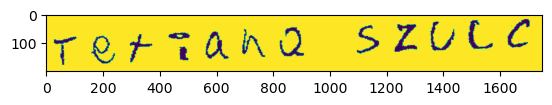

tetzana szulc
1/1 [==============================] - 0s 44ms/step


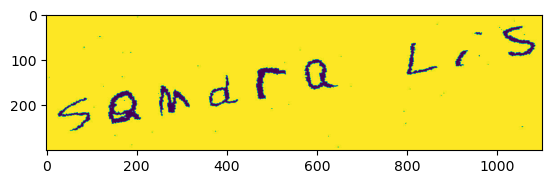

sandra lis
1/1 [==============================] - 0s 43ms/step


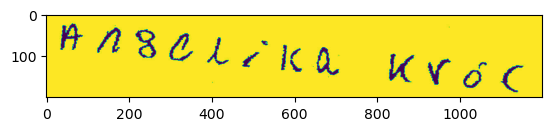

anrylika król
1/1 [==============================] - 0s 47ms/step


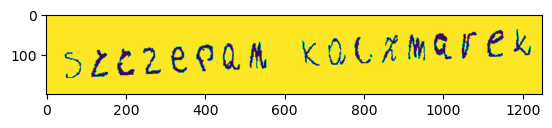

szczepan kaczmarek
1/1 [==============================] - 0s 44ms/step


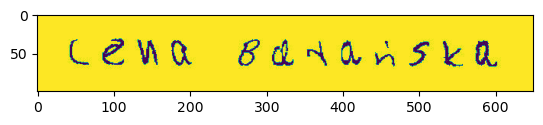

lena jadańska
1/1 [==============================] - 0s 48ms/step


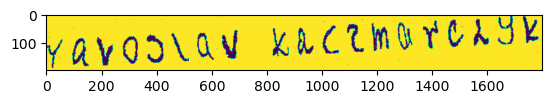

yarosław kaczmarczyk
1/1 [==============================] - 0s 46ms/step


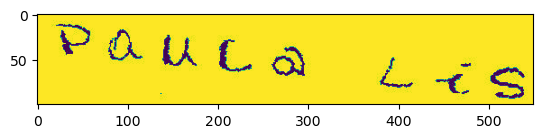

paula lis
1/1 [==============================] - 0s 44ms/step


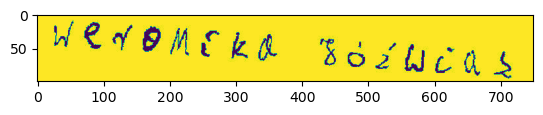

weronika sóęwiek
1/1 [==============================] - 0s 47ms/step


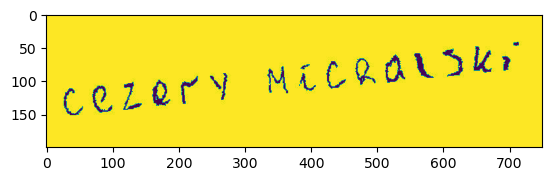

cezary michalski
1/1 [==============================] - 0s 43ms/step


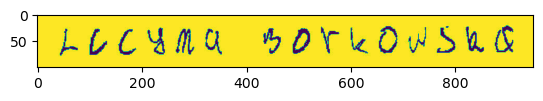

licyna borkowska


In [4]:
for i in range(10):
    temp = encode_single_sample(f"NN_TEST/img_{i}.jpg")
    out = model.predict(np.array([temp]))
    label = decode_batch_of_1(out)
    plt.imshow(PIL.Image.open(f"NN_TEST/img_{i}.jpg"))
    plt.show()
    print(label)

# Converting model to onnx

In [5]:
import onnx
import tf2onnx
tf2onnx.convert
onnx_model,_ = tf2onnx.convert.from_keras(model)
onnx.save_model(onnx_model, "model.onnx")

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'


In [6]:
import onnxruntime
sess = onnxruntime.InferenceSession("model.onnx")

In [7]:
input_name = sess.get_inputs()[0].name
input_shape = sess.get_inputs()[0].shape
input_type = sess.get_inputs()[0].type
print(f"Input Name: {input_name}, Input Shape: {input_shape}, Input Type: {input_type}")

Input Name: image, Input Shape: ['unk__379', 496, 128, 1], Input Type: tensor(float)


In [8]:
temp = encode_single_sample(f"NN_TEST/img_{1}.jpg")

In [9]:
output_name = sess.get_outputs()[0].name
output = sess.run([output_name], {input_name: np.array([temp])})

In [10]:
decode_batch_of_1(np.array(output[0]))

'sandra lis'

# Optimizing onnx model with open vino

Optimalization is done using following command in bash:
mo --input_model model.onnx --output_dir 

In [11]:
import openvino as ov

In [12]:
core = ov.Core()

In [13]:
model_openvino = core.read_model(model="model.xml")

In [14]:
compiled_model = core.compile_model(model=model_openvino, device_name="CPU")

In [15]:
output_layer = compiled_model.output(0)

In [16]:
result_infer = compiled_model([np.array([temp])])[output_layer]

In [17]:
decode_batch_of_1(np.array(result_infer))

'sandra lis'

# Time TEST
Testing time of calculations and accuracy of both base and optimized model

In [18]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [19]:
sample_amount = 1000
x_test = []
y_test = []
df = pd.read_csv("NN_TEST/data.csv")
for i in range(sample_amount):
    x_test.append(encode_single_sample(f"NN_TEST/img_{i}.jpg"))
    y_test.append(df["Labels"].iloc[i])


In [23]:
base_predictions = []
openvino_predictions = []
start_time = time.time()
for i in range(sample_amount):
    pred_model = model.predict(np.array([x_test[i]]),verbose=False)
    base_predictions.append(pred_model)
end_time = time.time()
elapsed_time = end_time - start_time
print("Time of making predictions with base model: "+str(elapsed_time)+"s")

start_time = time.time()
for i in range(sample_amount):
    pred_openvino = compiled_model([np.array([x_test[i]])])[output_layer]
    openvino_predictions.append(pred_openvino)
end_time = time.time()
elapsed_time = end_time - start_time
print("Time of making predictions with optimized model: "+str(elapsed_time)+"s")

Time of making predictions with base model: 144.16917419433594s
Time of making predictions with optimized model: 5.816126346588135s


In [26]:
acc_base = 0
similarity_base = 0
for i in range(sample_amount):
    truth =  y_test[i].lower()
    pred_base = decode_batch_of_1(base_predictions[i])
    similarity_base += similar(pred_base,truth)
    if pred_base==truth:
        acc_base+=1
print("Base model:")
print("Accuracy: ",acc_base/sample_amount)
print("Average similarity: ",similarity_base/sample_amount)

Base model:
Accuracy:  0.484
Average similarity:  0.9441231338795829


In [27]:
acc_ov = 0
similarity_ov = 0
for i in range(sample_amount):
    truth =  y_test[i].lower()
    pred_openvino = decode_batch_of_1(openvino_predictions[i])
    similarity_ov += similar(pred_openvino,truth)
    if pred_openvino==truth:
        acc_ov+=1
print("Optimized model:")
print("Accuracy: ",acc_ov/sample_amount)
print("Average similarity: ",similarity_ov/sample_amount)

Optimized model:
Accuracy:  0.486
Average similarity:  0.9442413049352542
